<a href="https://colab.research.google.com/github/dominiquebuford/AIPI540-project1/blob/dombuford/Detectron2_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🍕 Food Recognition Benchmark

Credits: This notebook is fork of notebook created by @shubhamai for previous iteration of the challenge. You can find the [original notebook here](https://www.aicrowd.com/showcase/food-recognition-challenge-data-exploration-baseline).

<br>

# Problem Statement
Detecting & Segmenting various kinds of food from an image. For ex. Someone got into new restaurent and get a food that he has never seen, well our DL model is in rescue, so our DL model will help indentifying which food it is from the class our model is being trained on!    

<img src="https://i.imgur.com/zS2Nbf0.png" width="300" />


# Dataset
We will be using data from Food Recognition Challenge - A benchmark for image-based food recognition challange which is running since 2020.


https://www.aicrowd.com/challenges/food-recognition-benchmark-2022#datasets

We have a total of **39k training images** with **3k validation set** and **4k public-testing set**. All the images are RGB and annotations exist in **MS-COCO format**.

<img src="https://lh5.googleusercontent.com/iySoTCAHFoEKxjvzELzCJKbZaTG2TzMcjuBxAlBVGupjkpE_XI1xNPnE71UIBthTu9_fZ4A1tz-ArABpI0DD2ZeF87qHPccRogEezd-UbhkQgZcQBYCE1HMeDusaKtj8ClCWjw-p">

# Evaluation

The evaluation metrics is IOU aka. Intersection Over Union ( more about that later ).

The actualy metric is computed by averaging over all the precision and recall values for IOU which greater than 0.5.

https://www.aicrowd.com/challenges/food-recognition-challenge#evaluation-criteria


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# What does this notebook contains?

1. Setting our Workspace 💼

2. Data Exploration 🧐
  - Reading Dataset
  - Data Visualisations

3. Image Visulisation 🖼️
   - Reading Images

4. Creating our Dataset 🔨
  - Fixing the Dataset
  - Creating our dataset

5. Creating our Model 🏭
   - Creating R-CNN Model
   - Setting up hyperparameters
   
6. Training the Model 🚂
  - Setting up Tensorboard
  - Start Training!

7. Evaluating the model 🧪
  - Evaluating our Model

7. Testing the Model 💯
  - Testing the Model

8. Submitting our predictions 📝

9. Generate More Data + Some tips & tricks 💡



# Setting our Workspace 💼

In this section we will be downloading our dataset, unzipping it & downliading detectron2 library and importing all libraries that we will be using

## Downloading & Unzipping our Dataset

In [ ]:
# Login to AIcrowd
!pip install aicrowd-cli > /dev/null
!aicrowd login

Please login here: https://api.aicrowd.com/auth/CUf6tZ5CaZCgmggstfjIQqha9K5gMw486pxQitxyeXM
/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening 'https://api.aicrowd.com/auth/CUf6tZ5CaZCgmggstfjIQqha9K5gMw486pxQitxyeXM'
API Key valid
Gitlab access token valid
Saved details successfully!


In [ ]:
# List dataset for this challenge
!aicrowd dataset list -c food-recognition-benchmark-2022

# Download dataset
!aicrowd dataset download -c food-recognition-benchmark-2022

                                    Datasets for challenge #962                                     
┌───┬─────────────────────────────────────────┬─────────────────────────────────────────┬──────────┐
│ # │ Title                                   │ Description                             │     Size │
├───┼─────────────────────────────────────────┼─────────────────────────────────────────┼──────────┤
│ 0 │ random_prediction.json                  │ Random prediction for Quick Submission  │  4.36 MB │
│   │                                         │ into Round 2                            │          │
│ 1 │ [Round 1]                               │ [Public] Testing Dataset (contains 3000 │     197M │
│   │ public_test_release_2.0.tar.gz          │ images and 498 categories, without      │          │
│   │                                         │ annotations)                            │          │
│ 2 │ [Round 1]                               │ Training Dataset (contains 39962 images │  

In [ ]:
# Create data directory
!mkdir -p data/ data/train data/val data/test
!cp *test* data/test && cd data/test && echo "Extracting test dataset" && tar -xvf *test* > /dev/null
!cp *val* data/val && cd data/val && echo "Extracting val dataset" &&  tar -xvf *val* > /dev/null
!cp *train* data/train && cd data/train && echo "Extracting train dataset" &&  tar -xvf *train* > /dev/null

Extracting test dataset
tar: public_test_release_2.1.tar.gz: Not found in archive
tar: Exiting with failure status due to previous errors
Extracting val dataset
tar: public_validation_set_release_2.1.tar.gz: Not found in archive
tar: Exiting with failure status due to previous errors
Extracting train dataset
tar: public_training_set_release_2.0.tar.gz: Not found in archive
tar: public_training_set_release_2.1.tar.gz: Not found in archive
tar: Exiting with failure status due to previous errors


So, the `data` directory is something like this:

<img src="https://images.aicrowd.com/uploads/ckeditor/pictures/674/content_carbon__3_.png" width="50%">

## Importing Necessary Libraries

In [25]:
# Making sure that we are using GPUs
!nvidia-smi

Sat Jan 27 02:13:27 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# Colab has cuda 11.1 pre-installed nowadays, downgrading to 1.9 for detectron2
!pip install -U torch==1.9.0+cu111 torchvision==0.10.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html
!pip install cython pyyaml==5.1
!pip install -U pycocotools
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version

Looking in links: https://download.pytorch.org/whl/torch_stable.html
ERROR: Could not find a version that satisfies the requirement torch==1.9.0+cu111 (from versions: 1.11.0, 1.11.0+cpu, 1.11.0+cu102, 1.11.0+cu113, 1.11.0+cu115, 1.11.0+rocm4.3.1, 1.11.0+rocm4.5.2, 1.12.0, 1.12.0+cpu, 1.12.0+cu102, 1.12.0+cu113, 1.12.0+cu116, 1.12.0+rocm5.0, 1.12.0+rocm5.1.1, 1.12.1, 1.12.1+cpu, 1.12.1+cu102, 1.12.1+cu113, 1.12.1+cu116, 1.12.1+rocm5.0, 1.12.1+rocm5.1.1, 1.13.0, 1.13.0+cpu, 1.13.0+cu116, 1.13.0+cu117, 1.13.0+cu117.with.pypi.cudnn, 1.13.0+rocm5.1.1, 1.13.0+rocm5.2, 1.13.1, 1.13.1+cpu, 1.13.1+cu116, 1.13.1+cu117, 1.13.1+cu117.with.pypi.cudnn, 1.13.1+rocm5.1.1, 1.13.1+rocm5.2, 2.0.0, 2.0.0+cpu, 2.0.0+cpu.cxx11.abi, 2.0.0+cu117, 2.0.0+cu117.with.pypi.cudnn, 2.0.0+cu118, 2.0.0+rocm5.3, 2.0.0+rocm5.4.2, 2.0.1, 2.0.1+cpu, 2.0.1+cpu.cxx11.abi, 2.0.1+cu117, 2.0.1+cu117.with.pypi.cudnn, 2.0.1+cu118, 2.0.1+rocm5.3, 2.0.1+rocm5.4.2, 2.1.0, 2.1.0+cpu, 2.1.0+cpu.cxx11.abi, 2.1.0+cu118, 2.1.0+cu121, 2.

In [ ]:
!nvidia-smi

Fri Jan 26 22:27:31 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
# install detectron2:
#!pip install -U detectron2==0.6+cu111 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/index.html

!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-2f0_k1yx
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-2f0_k1yx
  Resolved https://github.com/facebookresearch/detectron2.git to commit 59d9fb1b5593bf2b581e8f5a091a15e4a19fbd8b
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 77.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 18.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for detectron2: filename=detectron2-0.6-cp310-cp310-linux_x86_64.whl size=6119660 sha256=692c8b84d8d4c753f2988e0dfbb9

In [4]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import pandas as pd
import cv2
import json
from tqdm.notebook import tqdm

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.utils.visualizer import ColorMode
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# For reading annotations file
from pycocotools.coco import COCO

# utilities
from pprint import pprint # For beautiful print!
from collections import OrderedDict
import os

# For data visualisation
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from google.colab.patches import cv2_imshow

# Data Exploration 🧐

In this section we are going to read our dataset & doing some data visualisations

## Reading Data

In [7]:
# Reading annotations.json
TRAIN_ANNOTATIONS_PATH = "/content/drive/MyDrive/Masters-2/Deep Learning/Group Project 1 - CV/data/train/extracted_images/annotations.json"
TRAIN_IMAGE_DIRECTIORY = "/content/drive/MyDrive/Masters-2/Deep Learning/Group Project 1 - CV/data/train/extracted_images/images/"

VAL_ANNOTATIONS_PATH = "/content/drive/MyDrive/Masters-2/Deep Learning/Group Project 1 - CV/data/val/extracted_images/annotations.json"
VAL_IMAGE_DIRECTIORY = "/content/drive/MyDrive/Masters-2/Deep Learning/Group Project 1 - CV/data/val/extracted_images/images/"

train_coco = COCO(TRAIN_ANNOTATIONS_PATH)

loading annotations into memory...
Done (t=6.19s)
creating index...
index created!


In [8]:
# Reading the annotation files
with open(TRAIN_ANNOTATIONS_PATH) as f:
  train_annotations_data = json.load(f)

with open(VAL_ANNOTATIONS_PATH) as f:
  val_annotations_data = json.load(f)

In [9]:
train_annotations_data['annotations'][0]

{'id': 184135,
 'image_id': 131094,
 'category_id': 1352,
 'segmentation': [[115.0,
   206.5,
   98.0,
   204.5,
   74.5,
   182.0,
   65.0,
   167.5,
   47.5,
   156.0,
   39.5,
   137.0,
   39.5,
   130.0,
   51.0,
   118.5,
   62.00000000000001,
   112.5,
   76.0,
   113.5,
   121.5,
   151.0,
   130.5,
   169.0,
   131.5,
   185.0,
   128.5,
   195.0]],
 'area': 5059.0,
 'bbox': [39.5, 39.5, 167.0, 92.0],
 'iscrowd': 0}

## Data Format 🔍

Our COCO data format is something like this -

```
"info": {...},
"categories": [...],
"images": [...],
"annotations": [...],
```

In which categories is like this
```
[
  {'id': 2578,
  'name': 'water',
  'name_readable': 'Water',
  'supercategory': 'food'},
  {'id': 1157,
  'name': 'pear',
  'name_readable': 'Pear',
  'supercategory': 'food'},
  ...
  {'id': 1190,
  'name': 'peach',
  'name_readable': 'Peach',
  'supercategory': 'food'}
]
```

Info is empty ( not sure why )

images is like this

```
[
  {'file_name': '065537.jpg',
  'height': 464,
  'id': 65537,
  'width': 464},
  {'file_name': '065539.jpg',
  'height': 464,
  'id': 65539,
  'width': 464},
 ...
  {'file_name': '069900.jpg',
  'height': 391,
  'id': 69900,
  'width': 392},
]
```
Annotations is like this

```
{'area': 44320.0,
 'bbox': [86.5, 127.49999999999999, 286.0, 170.0],
 'category_id': 2578,
 'id': 102434,
 'image_id': 65537,
 'iscrowd': 0,
 'segmentation': [[235.99999999999997,
   372.5,
   169.0,
   372.5,
   ...
   368.5,
   264.0,
   371.5]]}
```


In [ ]:
# Reading all classes
category_ids = train_coco.loadCats(train_coco.getCatIds())
category_names = [_["name_readable"] for _ in category_ids]

print("## Categories\n-", "\n- ".join(category_names))

In [11]:
# Getting all categoriy with respective to their total images
no_images_per_category = {}

for n, i in enumerate(train_coco.getCatIds()):
  imgIds = train_coco.getImgIds(catIds=i)
  label = category_names[n]
  no_images_per_category[label] = len(imgIds)

img_info = pd.DataFrame(train_coco.loadImgs(train_coco.getImgIds()))
no_images_per_category = OrderedDict(sorted(no_images_per_category.items(), key=lambda x: -1*x[1]))

# Top 30 categories, based on number of images
i = 0
for k, v in no_images_per_category.items():
  print(k, v)
  i += 1
  if i > 30:
    break

Water 2928
Salad, leaf / salad, green 2002
Bread, white 1891
Tomato, raw  1865
Butter 1601
Carrot, raw 1482
Bread, wholemeal 1452
Coffee, with caffeine 1406
Rice 1024
Egg 1015
Mixed vegetables 892
Apple 892
Jam 797
Cucumber 742
Wine, red 728
Banana 654
Cheese 646
Potatoes steamed 644
Bell pepper, red, raw  549
Hard cheese 547
Espresso, with caffeine 547
Tea 516
Bread, whole wheat 504
Mixed salad (chopped without sauce) 498
Avocado 480
White coffee, with caffeine 470
Tomato sauce 466
Wine, white 430
Broccoli 421
Strawberries 412
Pasta, spaghetti 398


## Data Visualisations

In [12]:
fig = go.Figure([go.Bar(x=list(no_images_per_category.keys())[:50], y=list(no_images_per_category.values())[:50])])
fig.update_layout(
    title="No of Image per class",)

fig.show()

fig = go.Figure([go.Bar(x=list(no_images_per_category.keys())[50:200], y=list(no_images_per_category.values())[50:200])])
fig.update_layout(
    title="No of Image per class",)

fig.show()

fig = go.Figure([go.Bar(x=list(no_images_per_category.keys())[200:], y=list(no_images_per_category.values())[200:])])
fig.update_layout(
    title="No of Image per class",)

fig.show()

In [13]:
pprint(f"Average number of image per class : { sum(list(no_images_per_category.values())) / len(list(no_images_per_category.values())) }")
pprint(f"Highest number of image per class is : { list(no_images_per_category.keys())[0]} of { list(no_images_per_category.values())[0] }")
pprint(f"Lowest number of image per class is : Veggie Burger of { sorted(list(no_images_per_category.values()))[0] }")

'Average number of image per class : 141.359437751004'
'Highest number of image per class is : Water of 2928'
'Lowest number of image per class is : Veggie Burger of 12'


In [14]:
fig = go.Figure(data=[go.Pie(labels=list(no_images_per_category.keys()), values=list(no_images_per_category.values()),
                             hole=.3, textposition='inside', )], )
fig.update_layout(
    title="No of Image per class ( In pie )",)
fig.show()

In [15]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=img_info['height']))
fig.add_trace(go.Histogram(x=img_info['width']))

# Overlay both histograms
fig.update_layout(barmode='stack', title="Histogram of Image width & height",)


fig.show()

# Image Visulisation 🖼️

In this section  we are going to do imaghe visualisations!

In [16]:
print(img_info)

           id   file_name  width  height
0      131094  131094.jpg    480     480
1      131097  131097.jpg    391     390
2      131098  131098.jpg    391     390
3      131100  131100.jpg    391     390
4      131101  131101.jpg    391     390
...       ...         ...    ...     ...
39957  131017  131017.jpg    480     480
39958  131021  131021.jpg    464     464
39959  131053  131053.jpg    391     390
39960  131066  131066.jpg    464     464
39961  131071  131071.jpg    464     464

[39962 rows x 4 columns]


In [17]:
len(train_annotations_data['annotations'][n]['segmentation']), len(train_annotations_data['annotations'][n]['bbox'])

(1, 4)

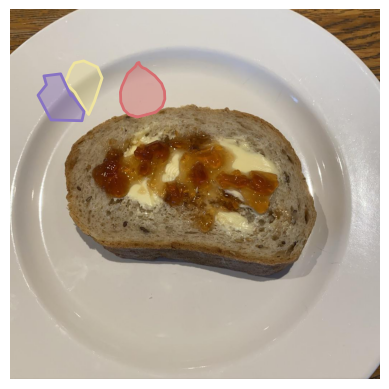

In [19]:
img_no = 7

annIds = train_coco.getAnnIds(imgIds=train_annotations_data['images'][img_no]['id'])
anns = train_coco.loadAnns(annIds)

# load and render the image
plt.imshow(plt.imread("/content/drive/MyDrive/Masters-2/Deep Learning/Group Project 1 - CV/data/train/extracted_images/images/186017.jpg"))
plt.axis('off')
# Render annotations on top of the image
train_coco.showAnns(anns)

In [ ]:
w, h = 15, 15 # Setting width and height of every image
rows, cols = 5, 5 # Setting the number of image rows & cols

fig = plt.figure(figsize=(15, 15)) # Making the figure with size

plt.title("Images")
plt.axis('off')

# Going thought every cell in rows and cols
for i in range(1, cols * rows+1):
  annIds = train_coco.getAnnIds(imgIds=img_info['id'][i])
  anns = train_coco.loadAnns(annIds)

  fig.add_subplot(rows, cols, i)

  # Show the image

  img = plt.imread(TRAIN_IMAGE_DIRECTIORY+img_info['file_name'][i])
  for i in anns:
    [x,y,w,h] = i['bbox']
    cv2.rectangle(img, (int(x), int(y)), (int(x+h), int(y+w)), (255,0,0), 2)
  plt.imshow(img)

  # Render annotations on top of the image
  train_coco.showAnns(anns)

  # Setting the axis off
  plt.axis("off")

# Showing the figure
plt.show()

# Creating our Dataset 🔨

In this section we are goind to fix out dataset first ( because there is some issues with dataset ( size mismatch ) & creating our dataset to put into the model

## Fixing the Data

In [20]:
np.array(train_annotations_data['annotations'][n]['segmentation']).shape , np.array(train_annotations_data['annotations'][n]['bbox']).shape

((1, 38), (4,))

In [24]:
# Function for taking a annotation & directiory of images and returning new annoation json with fixed image size info
def fix_data(annotations, directiory):
  for n, i in enumerate(tqdm((annotations['images']))):

      img = cv2.imread(directiory+i["file_name"])
      if img is not None:  #added by Dom, for some reason not all images are populating
        if img.shape[0] != i['height']:
            annotations['images'][n]['height'] = img.shape[0]
            print(i["file_name"])
            print(annotations['images'][n], img.shape)

        if img.shape[1] != i['width']:
            annotations['images'][n]['width'] = img.shape[1]
            print(i["file_name"])
            print(annotations['images'][n], img.shape)

  return annotations

train_annotations_data = fix_data(train_annotations_data, TRAIN_IMAGE_DIRECTIORY)

with open('data/train/new_ann.json', 'w') as f:
    json.dump(train_annotations_data, f)


  0%|          | 0/39962 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
def fix_data_val(annotations, directiory):
  for n, i in enumerate(tqdm((annotations['images']))):
      img = cv2.imread(directiory+i["file_name"])
      if img.shape[0] != i['height']:
          print(n)
          annotations['images'][n]['height'] = img.shape[0]
          print(i["file_name"])
          print(annotations['images'][n], img.shape)

      if img.shape[1] != i['width']:
          annotations['images'][n]['width'] = img.shape[1]
          print(i["file_name"])
          print(annotations['images'][n], img.shape)

  return annotations

val_annotations_data = fix_data_val(val_annotations_data, VAL_IMAGE_DIRECTIORY)

with open('data/val/new_ann.json', 'w') as f:
    json.dump(val_annotations_data, f)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
dict_addres = val_annotations_data['images'][748]
plt.imread(VAL_IMAGE_DIRECTIORY+dict_addres['file_name']).shape[:2], (dict_addres['height'], dict_addres['width'])

((918, 919), (918, 919))

## Loading Dataset

In [ ]:
train_annotations_path = 'data/train/new_ann.json'
train_images_path = 'data/train/images'

val_annotations_path = 'data/val/new_ann.json'
val_images_path = 'data/val/images'

In [ ]:
register_coco_instances("training_dataset", {},train_annotations_path, train_images_path)
register_coco_instances("validation_dataset", {},val_annotations_path, VAL_IMAGE_DIRECTIORY)

# Creating our Model 🏭

We are going to make an Faster R-CNN Model using Detectron2, and setting up hyperpamaters to train our model

## Creating R-CNN Model

In [ ]:
cfg = get_cfg()
# Check the model zoo and use any of the models ( from detectron2 github repo)
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("training_dataset",)
cfg.DATASETS.TEST = ()

cfg.DATALOADER.NUM_WORKERS = 2
# Loading pre trained weights
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")

## Setting up hyperparameters

In [ ]:
# No. of Batchs
cfg.SOLVER.IMS_PER_BATCH = 10

# Learning Rate:
cfg.SOLVER.BASE_LR = 0.0025

# No of Interations
cfg.SOLVER.MAX_ITER = 50001

# Images per batch (Batch Size)
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128

# No of Categories(Classes) present
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 498

cfg.OUTPUT_DIR = "logs/"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [ ]:
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)

[12/21 07:39:41 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (499, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (499,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (1992, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (1992,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (498, 2

# Training the Model 🚂

Setting up Tensorboard & finally training our model!

## Setting up Tensorboard

In [ ]:
%load_ext tensorboard

In [ ]:
#%tensorboard --logdir logs

## Start Training!

In [ ]:
trainer.train()

# Evaluating the model 🧪

After training is done, we will evaluate our model to see how it's performing in the unseen images!

In [ ]:
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.01

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

evaluator = COCOEvaluator("validation_dataset", cfg, False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, "validation_dataset")
valResults = inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [12/20 22:27:53 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/20 22:27:53 d2.data.datasets.coco]: Loaded 1000 images in COCO format from data/val/new_ann.json
[12/20 22:27:53 d2.data.build]: Distribution of instances among all 498 categories:
|   category    | #instances   |   category    | #instances   |   category    | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|:-------------:|:-------------|
| beetroot-st.. | 5            | carrot-stea.. | 2            | mushroom-av.. | 2            |
| savoy-cabba.. | 0            | zucchini-st.. | 0            | vanille-cre.. | 0            |
| shrimp-boiled | 3            | spinach-ste.. | 2            |  spinach-raw  | 2            |
| green-bean-.. | 1            | sweet-corn-.. | 2            | watermelon-.. | 5            |
| pizza-with-.. | 1            | pizza-with-.. | 1            | pizza-with-.. | 2            |
| bell-peppe

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.01
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 498

cfg.DATASETS.TEST = ("validation_dataset", )
predictor = DefaultPredictor(cfg)

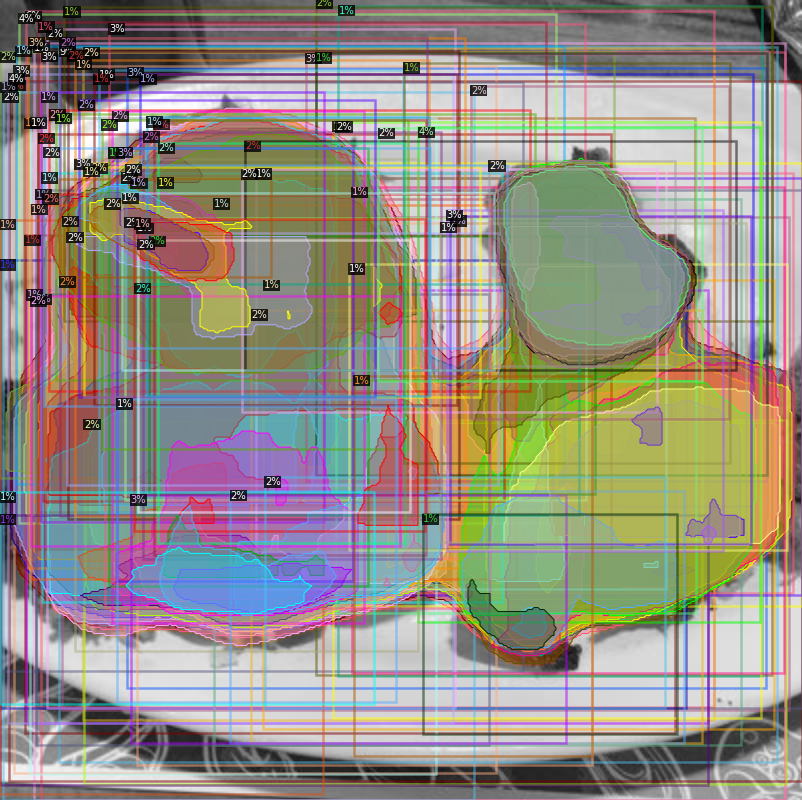

In [ ]:
val_metadata = MetadataCatalog.get("val_dataset")

im = cv2.imread("data/val/images/085220.jpg")

outputs = predictor(im)

v = Visualizer(im[:, :, ::-1],
                   metadata=val_metadata,
                   scale=2,
                   instance_mode=ColorMode.IMAGE_BW
    )

out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
#!bash <(curl -sL https://gitlab.aicrowd.com/jyotish/food-recognition-challenge-detectron2-baseline/raw/master/utils/submit-colab.sh)

# Data Argumentation

In [ ]:
!pip install --upgrade fastai

In [ ]:
from fastai.vision.core import *
from fastai.vision.utils import *
from fastai.vision.augment import *
from fastai.data.core import *
from fastai.data.transforms import *

In [ ]:
images, lbl_bbox = get_annotations('data/train/annotations.json')\

In [ ]:
idx=14
coco_fn,bbox = 'data/train/images/'+images[idx],lbl_bbox[idx]

def _coco_bb(x):  return TensorBBox.create(bbox[0])
def _coco_lbl(x): return bbox[1]


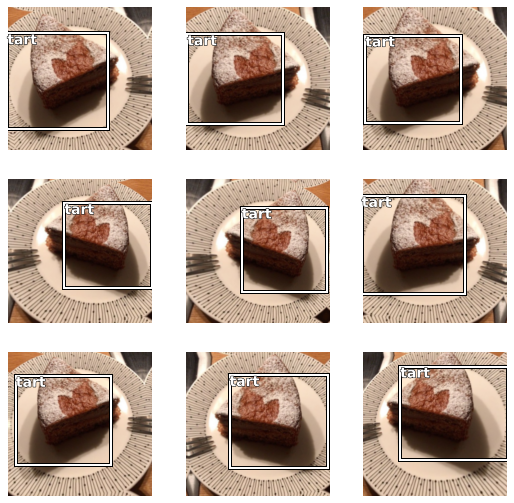

In [ ]:
coco_dsrc = Datasets([coco_fn]*10, [PILImage.create, [_coco_bb,], [_coco_lbl, MultiCategorize(add_na=True)]], n_inp=1)
coco_tdl = TfmdDL(coco_dsrc, bs=9, after_item=[BBoxLabeler(), PointScaler(), ToTensor(), Resize(256)],
                  after_batch=[IntToFloatTensor(), *aug_transforms()])

coco_tdl.show_batch(max_n=9)